# Kernelized Support Vector Machines (커널 서포트 벡터 머신)
#### 입력 데이터에서 단순한 초평명(hyperplane)으로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장한 것
ESLR 12장에서 자세한 내용 볼 수 있다.
http://statweb.stanford.edu/~tibs/ElemStatLearn/

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Intro to ML basic libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

from sklearn.model_selection import train_test_split
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 선형 모델과 비선형 특성

Text(0, 0.5, 'feature 1')

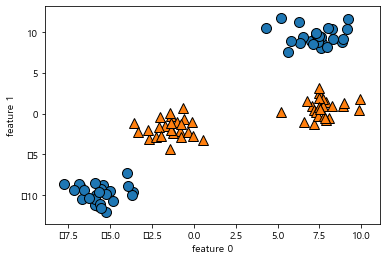

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2  # 2로 나눈 나머지

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

In [4]:
# 선형적으로 구분되지 않는 클래스를 가진 이진 분류 데이터셋

Text(0, 0.5, 'feature 1')

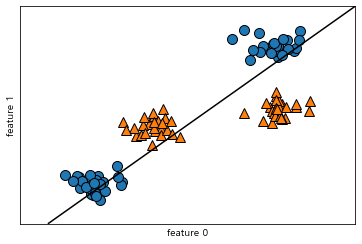

In [5]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

In [6]:
# 선형 모델을 유연하게 만드는 한 가지 방법: 특성끼리 곱하거나 거듭제곱하여 새로운 특성 추가.
# 아하, (특성) 차원이 하나 증가했기 때문에 2d -> 3d로 바뀌고, 같은 선형이라도 분류가 더 잘되는 구나!

Text(0.5, 0, 'feature 1의 제곱')

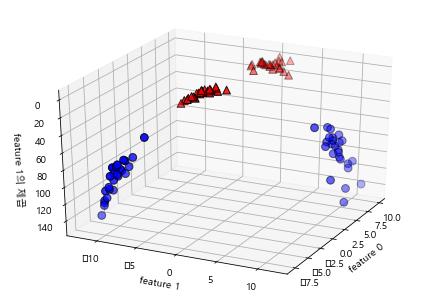

In [7]:
X_new = np.hstack([X, X[:, 1:] ** 2]) # 두 번째 특성을 제곱

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)

# y==0인 포인트 먼저 그린 다음 y==1 포인트 그림
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')
ax.set_zlabel('feature 1의 제곱')

Text(0.5, 0, 'feature 1의 제곱')

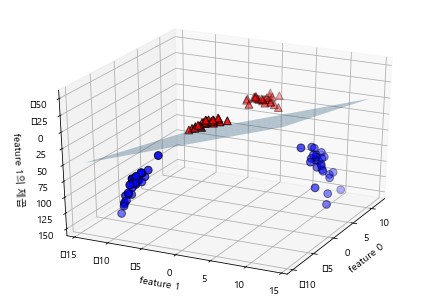

In [8]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)

ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')
ax.set_zlabel('feature 1의 제곱')

In [9]:
# 확장된 3차원 데이터셋에서 선형 SVM이 만든 결정 경계: 이를 A라고 하자.

Text(0, 0.5, 'feature 1')

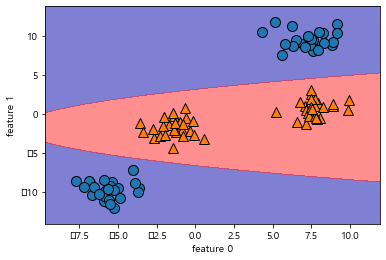

In [10]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

In [11]:
# 원래 두 개 특성에 투영한 A의 결정 경계

### Kernel trick (커널 기법)
#### 수학적 기교를 사용해 새로운 특성을 많이 만들지 않고서도 고차원 분류기를 학습시킬 수 있다.
#### 실제로 데이터를 확장하지 않고 확장된 특성에 대한 데이터 포인트들의 거리 (정확히는 스칼라 곱) 를 계산한다.
- 다항식 커널: 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산 (특성1^2 * 특성^5 등)
- 가우시안(Gaussian) 커널: (=RBF커널. Radial Basis Function) 차원이 무한한 특성 공간에 매핑. 모든 차수의 모든 다항식 고려, but 특성의 중요도는 고차항이 될 수록 줄어든다. (지수 함수의 테일러 급수 전개 때문)

가우시안 커널은 지수 함수의 테일러 전개를 이용한 것으로 무한한 다항식 차원으로 매핑하는 효과를 만든다.

### SVM
#### 각 훈련 데이터 포인트가 두 클래스 사이의 결정 경계를 구분하는 데 얼마나 중요한지 학습
#### support vectors: 두 클래스 사이의 경계에 위치한 데이터 포인터들. 결정 경계를 만든는 데 영향을 미치는 일부 훈련 데이터.
#### 새로운 데이터 포인트 예측: 각 서포트 벡터와의 거리 측정.

### Krbf (x1, x2) = exp( -gamma || x1 - x2 || ^2 )
가우시안 커널.
- x1, x2: 데이터 포인트.
- ||x1 - x2||: 유클리디안 거리.
- gamma: 가우시안 커널의 폭을 제어하는 매개변수

Text(0, 0.5, 'feature 1')

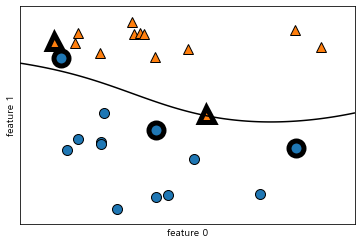

In [12]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)

# 데이터 포인트 그리기
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# 서포트 벡터
sv = svm.support_vectors_

# dual_coef_ 의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됨
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=5)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

### SVM 매개변수 튜닝
#### r (gamma): 가우시안 커널 폭의 역수. 하나의 훈련 샘플이 미치는 영향의 범위 결정. 작은 값->넓은 영역, 큰 값->영향 미치는 범위 제한적. 가우시안 커널 반경이 클수록 훈련 샘플의 영향 범위는 크다.
#### C: 선형모델에서 사용한 것과 비슷한 규제 매개변수. 각 포인트의 중요도(dual_coef_ 값)를 제한한다.

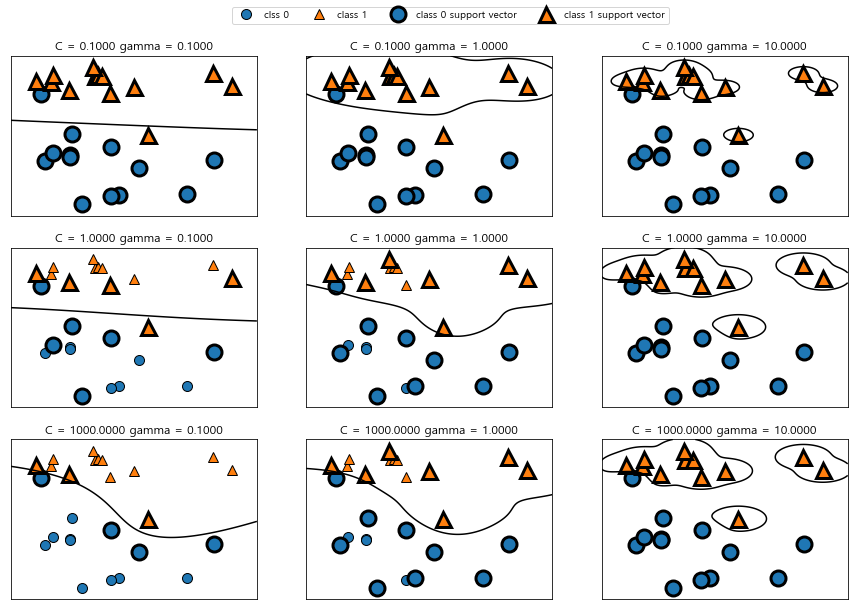

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(['clss 0', 'class 1', 'class 0 support vector', 'class 1 support vector'], ncol=4, loc=(.9, 1.2))

In [14]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print('train acc: {:.3f}'.format(svc.score(X_train, y_train)))
print('test acc: {:.3f}'.format(svc.score(X_test, y_test)))

train acc: 1.000
test acc: 0.629


In [15]:
# 과대적합. SVM은 매개변수 설정과 데이터 스케일에 매우 민감하다. 입력 특성의 범위 비슷해야함! 특성별 최소 최대값 로그 스케일로 표현.

Text(0, 0.5, '특성 크기')

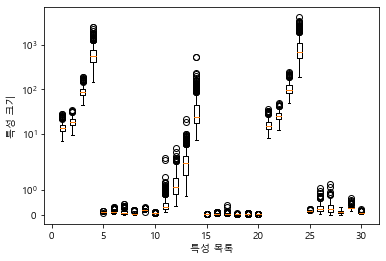

In [18]:
plt.boxplot(X_train, manage_ticks=False)
plt.yscale('symlog')
plt.xlabel('특성 목록')
plt.ylabel('특성 크기')

### SVM을 위한 데이터 전처리
#### StandardScaler, MinMaxScaler 전처리 메서드

#### MinMaxScaler:  ( X - min(X) ) / max(X) - min(X) )
- 항상 0과 1 사이의 값이 된다

In [19]:
# 훈련 세트에서 특성별 최소값 계산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별 (최대값 - 최소값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

X_train_scaled = (X_train - min_on_training) / range_on_training

print('특성별 최소값\n', X_train_scaled.min(axis=0))
print('특성별 최대값\n', X_train_scaled.max(axis=0))

특성별 최소값
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
특성별 최대값
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [20]:
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)

print('train acc: {:.3f}'.format(svc.score(X_train_scaled, y_train)))
print('test acc: {:.3f}'.format(svc.score(X_test_scaled, y_test)))

train acc: 0.948
test acc: 0.951


In [21]:
# 훈련 세트 정확도와 테스트 세트 정확도가 거의 같으므로 과소적합.

In [22]:
# C나 gamma 값을 증가시켜 좀 더 복잡한 모델 만들 수 있다.

In [23]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print('train acc: {:.3f}'.format(svc.score(X_train_scaled, y_train)))
print('test acc: {:.3f}'.format(svc.score(X_test_scaled, y_test)))

train acc: 0.988
test acc: 0.972


#### SVM 장단점
- 데이터 특성이 몇 개 없어도 복잡한 결정 경계 생성 가능. 저차원과 고차원 데이터에 모두 잘 작동.
- 샘플이 많을 때 (100000개 이상인 경우 메모리 관점에서 도전적인 과제...) 비효율적.
- 데이터 전처리와 매개변수 설정에 신경을 많이 써야함. (랜덤 포레스트나 그래디언트 부스팅의 경우 전처리 거의 필요 없음)
- 모델을 분석하기 힘들다. 모든 특성이 비슷한 단위이고 스케일이 비슷할 때 추천.

# 2.3.9 신경망 (Neural Networks, Deep Learning)
- 다층 퍼셉트론 (MLP, Multilayer perceptrons, feed-forward NN, (fully connected) NN) 복잡한 딥러닝 알고리즘의 출발점이며 비교적 간단하게 분류와 회귀에 쓸 수 있다.

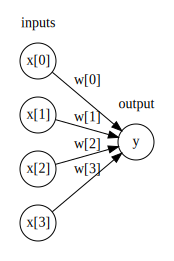

In [24]:
mglearn.plots.plot_logistic_regression_graph()

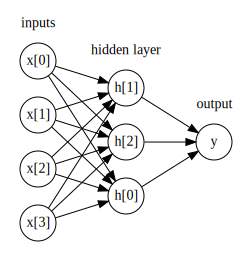

In [25]:
mglearn.plots.plot_single_hidden_layer_graph()

### ReLU (Rectified Linear Unit)
### tanh (Hyperbolic Tangent)

Text(0, 0.5, 'relu(x), tanh(x)')

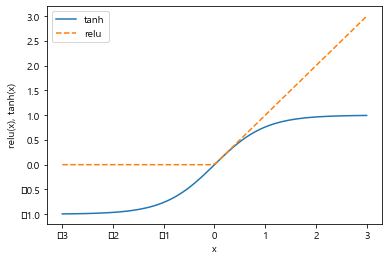

In [26]:
line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label='tanh')
plt.plot(line, np.maximum(line, 0), linestyle='--', label='relu')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('relu(x), tanh(x)')

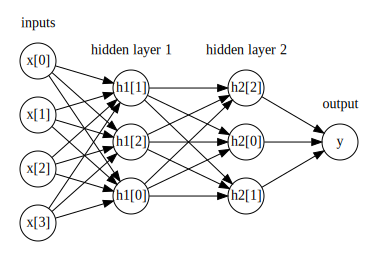

In [27]:
mglearn.plots.plot_two_hidden_layer_graph()

Text(0, 0.5, 'feature 1')

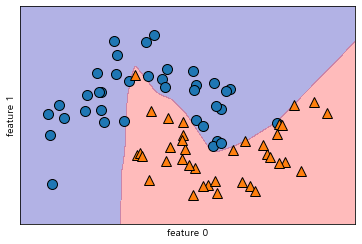

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train) # hidden_layer_sizes = 100 (unit 100개)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

Text(0, 0.5, 'feature 1')

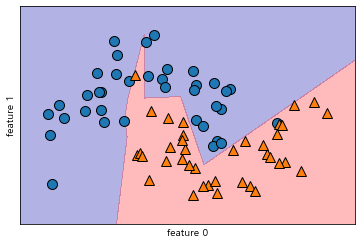

In [29]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]).fit(X_train, y_train) # 유닛 10개로
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

Text(0, 0.5, 'feature 1')

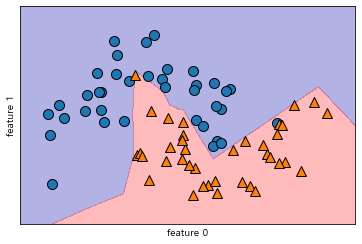

In [30]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10]).fit(X_train, y_train) # 유닛 10개짜리 두 개 은닉층
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

# 기본 비선형 함수는 ReLU. tanh로 바꿔도 됨.

Text(0, 0.5, 'feature 1')

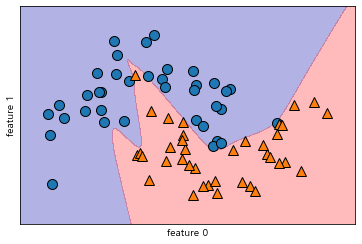

In [31]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10], activation='tanh').fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

# tanh activation function

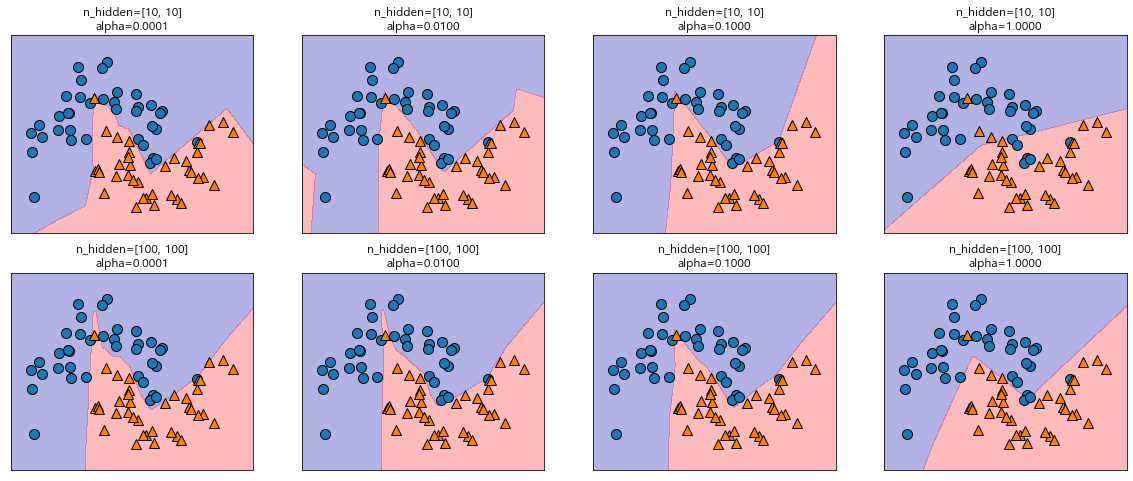

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for axx, n_hidden_nodes in zip(axes, [10, 100]):
    for ax, alpha in zip(axx, [0.0001, 0.01, 0.1, 1]):
        mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes], alpha=alpha)
        mlp.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,ax=ax)
        ax.set_title('n_hidden=[{}, {}]\nalpha={:.4f}'.format(n_hidden_nodes, n_hidden_nodes, alpha))

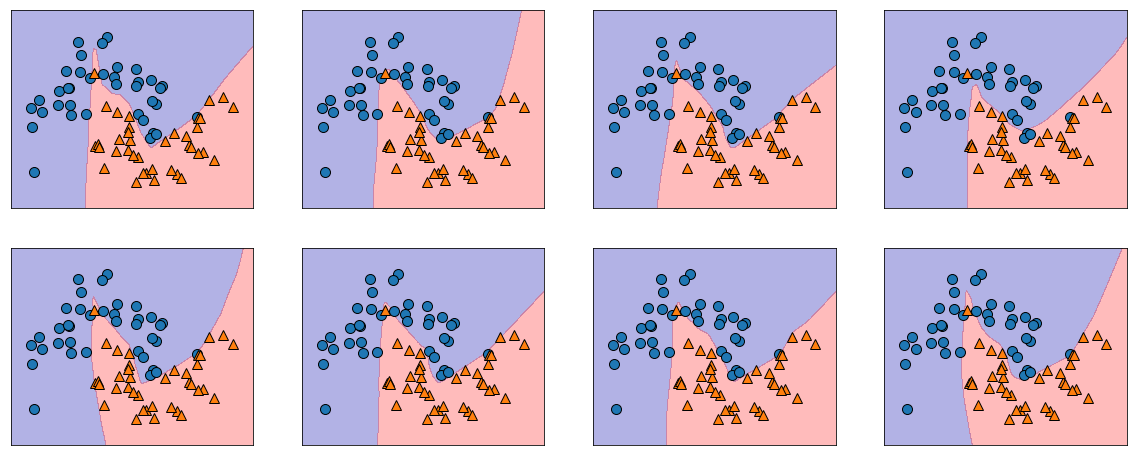

In [28]:
fig, axes = plt.subplots(2, 4, figsize = (20, 8))
for i, ax in enumerate(axes.ravel()):
    mlp = MLPClassifier(solver='lbfgs', random_state=i, hidden_layer_sizes=[100, 100])
    mlp.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,ax=ax)

In [29]:
# 무작위로 다른 초기값 (random_state 다르게), 매개변수는 같게 -> 학습 다르게됨. 결정 경계 다름.

In [33]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

print('유방암 데이터의 특성별 최대값:\n',cancer.data.max(axis=0))

유방암 데이터의 특성별 최대값:
 [2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01 3.454e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 4.885e+00 2.198e+01 5.422e+02
 3.113e-02 1.354e-01 3.960e-01 5.279e-02 7.895e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.910e-01
 6.638e-01 2.075e-01]


In [59]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print('train acc: {:.3f}  '.format(mlp.score(X_train, y_train)), 'test acc: {:.3f}'.format(mlp.score(X_test, y_test)))

train acc: 0.939   test acc: 0.916


In [42]:
# 데이터를 z-score (standard score, 평균 0 분산 1인 표준정규분포) 로 스케일링. 

In [54]:
A = np.array([[1, 2, 3],
              [2, 3, 4]])

A.mean(axis=0)

array([1.5, 2.5, 3.5])

In [60]:
mean_on_train = X_train.mean(axis=0) # 각 특성별 평균
std_on_train = X_train.std(axis=0)

# 데이터에서 평균을 빼고 표준 편차로 나눠주면 된다.
X_train_scaled = (X_train - mean_on_train) / std_on_train
X_test_scaled = (X_test - mean_on_train) / std_on_train

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)

print('train acc: {:.3f}  '.format(mlp.score(X_train_scaled, y_train)), 'test acc: {:.3f}'.format(mlp.score(X_test_scaled, y_test)))

train acc: 0.991   test acc: 0.965


In [61]:
mlp = MLPClassifier(max_iter=1000, random_state=0) # 반복 횟수를 늘려 성능 향상 200 -> 1000
mlp.fit(X_train_scaled, y_train)

print('train acc: {:.3f}  '.format(mlp.score(X_train_scaled, y_train)), 'test acc: {:.3f}'.format(mlp.score(X_test_scaled, y_test)))

train acc: 1.000   test acc: 0.972


In [62]:
mlp = MLPClassifier(max_iter=1000, alpha=1 ,random_state=0) # alpha 매개변수를 0.0001 -> 1 크게 향상. 규제 커지므로 일반화 향상.
mlp.fit(X_train_scaled, y_train)

print('train acc: {:.3f}  '.format(mlp.score(X_train_scaled, y_train)), 'test acc: {:.3f}'.format(mlp.score(X_test_scaled, y_test)))

train acc: 0.988   test acc: 0.972


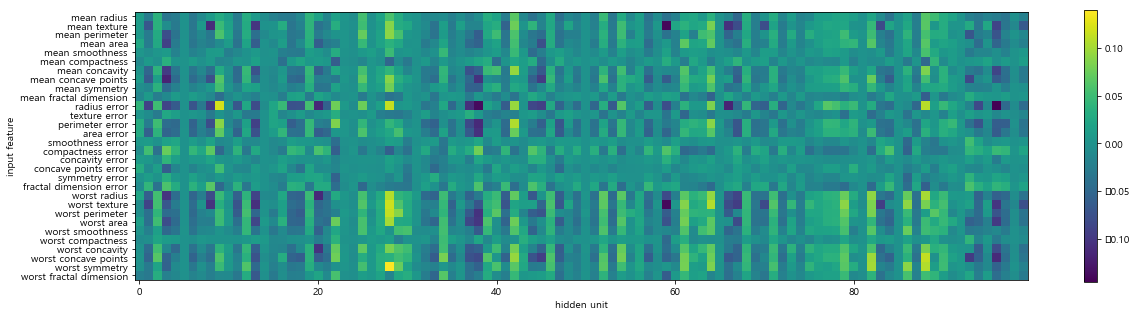

In [63]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel('hidden unit')
plt.ylabel('input feature')
plt.colorbar()

In [64]:
# 학습시킨 신경망 첫번째 층의 가중치 히트맵(heat map)

### 신경망 장단점
- 대량의 데이터에 내재된 정보를 잡아내고 매우 복잡한 모델 만들 수 있다.
- 학습이 오래 걸리고 데이터 전처리에 주의해야한다.
- 모든 특성이 같은 의미를 가진 동질의 데이터에서 잘 작동 (특성들이 이질적이면 트리 기반 모델이 더 잘될 수 있음)
- 매개변수 튜닝이 쉽지 않음. 예술의 영역

### solver 매개변수
- adam: 대부분의 경우 잘 작동하지만, 데이터의 스케일에 민감 (평균 0, 분산 1로 조정하면 잘 된다.)
- lbfgs (Limited-memory BFGS): BFGS ( Broyden - Fletcher - Goldfarb - Shanno; 알고리즘 연구자들 이름)는 의사 뉴턴 메서드 (Newton Method) 중 하나로, 안정적이지만 규모가 큰 모델이나 대량의 데이터셋에서 시간이 너무 오래 걸리므로, 이를 해결한 (제한된 메모리 공간에서 구현) 모델이 l-bfgs.
- sgd: momentum과 nesterovs_momentum 매개변수 설정.